In [1]:
import torch
from transformers import MT5ForConditionalGeneration, MT5Config, MT5EncoderModel, MT5Tokenizer, Trainer, TrainingArguments
from progeny_tokenizer import TAPETokenizer
import numpy as np
import math
import random
import scipy
import time
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, Dataset, BatchSampler
import typing
from pathlib import Path
import argparse
from collections import OrderedDict
import pickle
import pathlib

import matplotlib.pyplot as plt

# Analyze FoldX ddG values of gen 10K

In [2]:
from tape.metrics import spearmanr

In [3]:
# results_tsv_name = "foldx_sim_results/unique250K_small_clspool_waeDeterencStart84kstep512dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-070-congen_seqs260000_top10Klatentheadfiltered/results_full.tsv"
# ddG_df = pd.read_table(results_tsv_name)

In [4]:
results_tsv_dir = "foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered"

results_tsv_dir_path = pathlib.Path(results_tsv_dir)

results_tsv_files = list(results_tsv_dir_path.glob('results_batch*to*.tsv'))
print("results_tsv_files: ", results_tsv_files)
results_tsv_df_full = None
print("Merging result tsv files")
for tsv_ind, results_tsv_file in enumerate(results_tsv_files):
    print("tsv_ind: ", tsv_ind) 
    print("results_tsv_file: ", results_tsv_file)
    if tsv_ind == 0:
        results_tsv_df_full = pd.read_table(results_tsv_file)
    else:
        results_tsv_df = pd.read_table(results_tsv_file)
        results_tsv_df_full = results_tsv_df_full.append(results_tsv_df, ignore_index=True)

results_tsv_files:  [PosixPath('foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch30_7500to7749.tsv'), PosixPath('foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch11_2750to2999.tsv'), PosixPath('foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch15_3750to3999.tsv'), PosixPath('foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch31_7750to7999.tsv'), PosixPath('foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfi

tsv_ind:  21
results_tsv_file:  foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch19_4750to4999.tsv
tsv_ind:  22
results_tsv_file:  foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch39_9750to9999.tsv
tsv_ind:  23
results_tsv_file:  foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch0_0to249.tsv
tsv_ind:  24
results_tsv_file:  foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_batch18_4500to4749.tsv
tsv_ind:  25
results_tsv_file:  foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kst

In [5]:
ddG_df = results_tsv_df_full

In [6]:
ddG_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG
0,2.870699,-11.351077,STIEEQAKTFLDKFKHEAEDLFYQSTLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFKHEAEDLFYQSTLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.37372
1,2.864015,-11.350984,STIEEQAKQFLDKFNHEALDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKQFLDKFNHEAEPLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.75880
2,2.866637,-11.350789,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENYQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.64235
3,2.830233,-11.350729,STIEEQAKTFLMKFNHEAEDLFYQSSLTQMNYNTNITEENVQNMNN...,STIEEQAKTMLDKFNHEAEDLFYQSSLTNWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.80446
4,2.920205,-11.350695,STIEELAKMFLMRFNHEAERLFYQSSLASMNYNTNITEENVQNMNN...,STIEELAKWFLWQFNHEAEFLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.05101
...,...,...,...,...,...,...,...,...,...,...,...
9995,2.844780,-12.188685,SDIEEQAKTFLDKFNHEAEDLFYQSSLAKMNYNTNITEENVQNMRN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMRN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.00398
9996,2.848111,-12.187910,SSIEELAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQFMNN...,SSIEELAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQFMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.47509
9997,2.858779,-12.187255,SDIEEQAKTFLDKFNHEAEDLFYISMLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYISWLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.32746
9998,3.040434,-12.186877,SDIEEMAKTFLDKFNHMATDLFYQFMLASMNYNTNITEENVQNMNN...,SDIEEWAKTFLDKFNHMAVDLFYQRWLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-10.83210


In [7]:
disc_pred_list = ddG_df['disc_pred']
ddG_list = ddG_df['ddG']

In [8]:
disc_ddG_cor = spearmanr(disc_pred_list, ddG_list)

In [9]:
disc_ddG_cor

-0.46933308109037053

In [10]:
latent_head_pred_list = ddG_df['latent_head_pred']
ddG_list = ddG_df['ddG']
latent_head_ddG_cor = spearmanr(latent_head_pred_list, ddG_list)
print("latent_head_ddG_cor: ", latent_head_ddG_cor)

latent_head_ddG_cor:  0.4368448464859343


In [11]:
# Disc-predicted most stable ones first
ddG_df = ddG_df.sort_values(by='latent_head_pred', ascending=True)
# ddG_df = ddG_df.sort_values(by='disc_pred', ascending=True)

In [12]:
ddG_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG
5750,3.030911,-14.308747,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMEN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-9.18707
5751,2.938221,-13.744923,SDIEEQAKSFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.57481
5752,2.985047,-13.611472,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.11275
5753,2.949520,-13.560543,SNIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMEN...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.05138
5754,2.961349,-13.530456,STIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMNQ...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.10874
...,...,...,...,...,...,...,...,...,...,...,...
5745,2.866493,-11.192046,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.86621
5746,2.874120,-11.192026,STIEEQAKTFLAKFNHEAELLFYQSTLKSMNYNTNITEENVQNMNN...,STIEEQAKTFLAKFNHEAELLFYQSTLKSWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.28894
5747,2.915616,-11.191988,FTIEEQAKTFLDKFNHEAEDLFNQSLLASMNYNTNITEENVQMMNN...,FTIEEQAKTFLDKFNHEAEDLFNQSLLASWNYNTNITEENVQWMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.79960
5748,2.803876,-11.191913,SDIEEQAKQFLDKFNHEAEDLFYQSSLSSMNYNTNITEENVQNMNN...,SDIEEQAKQFLDKFNHEAEDLFYQSSLATWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.32901


In [13]:
top_half_stable_df = ddG_df[:len(ddG_df)//2]

In [14]:
top_half_stable_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG
5750,3.030911,-14.308747,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMEN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-9.18707
5751,2.938221,-13.744923,SDIEEQAKSFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.57481
5752,2.985047,-13.611472,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.11275
5753,2.949520,-13.560543,SNIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMEN...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.05138
5754,2.961349,-13.530456,STIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMNQ...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.10874
...,...,...,...,...,...,...,...,...,...,...,...
5495,2.779738,-11.552601,SDIEEQAKTFLDKFNHDAEDLFYQSSLASMSYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWSYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.72055
5496,2.921501,-11.552591,STIEEQAKHFLDKFNHEAEFLFYQSSLASMEYNTNITEENVMIMNN...,STIEEQAKHFLDKFNHEAEFLFYQSSLASWRYNTNITEENVQDMYN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.02233
5497,2.886292,-11.552409,STIEEQAKHFLDKFNHMAERLFYQSSLARMNYNTNITEENVQNMNN...,STIEEQAKHFLDKFNHLAEILFYQSSLAQWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.63658
5498,2.961885,-11.551899,STIEEQAKTFLDKFNHEAEDLFYQFMLASMMYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQFLLASWIYNTNITEENVQNMRN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.79783


In [15]:
gen_train_data = 'data/gen_train_data/top_half_ddG/train_ddG.pkl'

In [16]:
gen_train_df = pd.read_pickle(gen_train_data)

In [17]:
gen_train_ddG_list = gen_train_df['ddG']

In [18]:
len(ddG_list)

10000

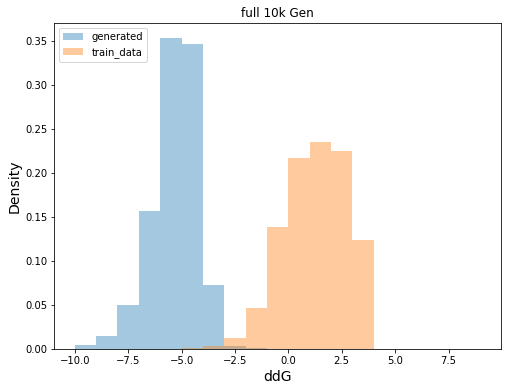

In [19]:
plt.figure(figsize=(8,6))
plt.hist(ddG_list, density=True, label='generated', bins=[i for i in range(-10, 10)], alpha=0.4)

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

In [20]:
len(top_half_stable_df['ddG'])

5000

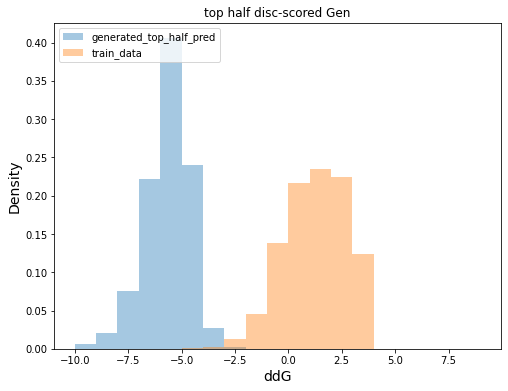

In [21]:
plt.figure(figsize=(8,6))
plt.hist(top_half_stable_df['ddG'], density=True, label='generated_top_half_pred', bins=[i for i in range(-10, 10)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("top half disc-scored Gen")
plt.legend(loc='upper left')

In [22]:
np.max(top_half_stable_df['ddG'])

12.4045

In [23]:
np.min(top_half_stable_df['ddG'])

-12.7226

In [24]:
np.mean(top_half_stable_df['ddG'])

-5.6709310706

In [25]:
np.median(top_half_stable_df['ddG'])

-5.559255

In [26]:
np.max(gen_train_ddG_list)

3.5751

In [27]:
np.min(gen_train_ddG_list)

-6.59818

In [28]:
np.mean(gen_train_ddG_list)

1.26221709496

In [29]:
np.median(gen_train_ddG_list)

1.3439199999999998

## plot top 100, 1k and 10k distribution

In [30]:
# rank_by_col = 'disc_pred'
rank_by_col = 'latent_head_pred'

In [31]:
ddG_df = ddG_df.sort_values(by=rank_by_col, ascending=True)
disc_pred_list = ddG_df[rank_by_col]

ddG_list = ddG_df['ddG']

topk:  10000
topk_disc_ddG_cor:  0.4368448464859343
topk:  1000
topk_disc_ddG_cor:  0.3756578530387737
topk:  100
topk_disc_ddG_cor:  0.4131293129312931


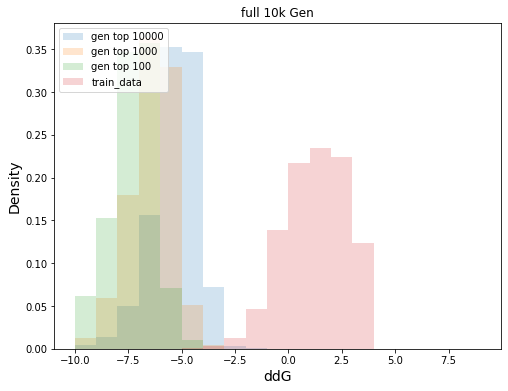

In [32]:
topk_hist_list = [10000, 1000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)



plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

topk:  10000
topk_disc_ddG_cor:  0.4368448464859343
topk:  100
topk_disc_ddG_cor:  0.4131293129312931


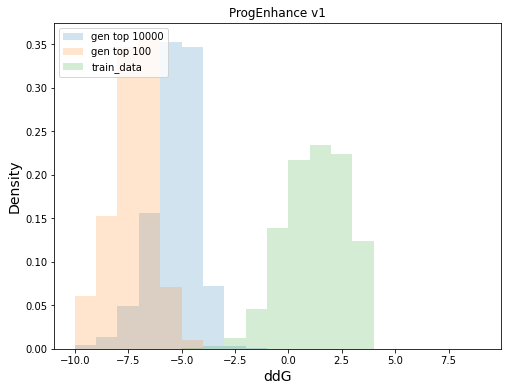

In [33]:
topk_hist_list = [10000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)


plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("ProgEnhance v1")
plt.legend(loc='upper left')

top 10, 100, 1000 by disc ranking

In [34]:
ddG_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG
5750,3.030911,-14.308747,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMEN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-9.18707
5751,2.938221,-13.744923,SDIEEQAKSFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.57481
5752,2.985047,-13.611472,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.11275
5753,2.949520,-13.560543,SNIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMEN...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.05138
5754,2.961349,-13.530456,STIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMNQ...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.10874
...,...,...,...,...,...,...,...,...,...,...,...
5745,2.866493,-11.192046,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.86621
5746,2.874120,-11.192026,STIEEQAKTFLAKFNHEAELLFYQSTLKSMNYNTNITEENVQNMNN...,STIEEQAKTFLAKFNHEAELLFYQSTLKSWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.28894
5747,2.915616,-11.191988,FTIEEQAKTFLDKFNHEAEDLFNQSLLASMNYNTNITEENVQMMNN...,FTIEEQAKTFLDKFNHEAEDLFNQSLLASWNYNTNITEENVQWMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.79960
5748,2.803876,-11.191913,SDIEEQAKQFLDKFNHEAEDLFYQSSLSSMNYNTNITEENVQNMNN...,SDIEEQAKQFLDKFNHEAEDLFYQSSLATWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.32901


In [35]:
topK_list = [10, 100, 1000, 10000]

In [36]:
topK_df = ddG_df[:10]
topK_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG
5750,3.030911,-14.308747,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMEN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-9.18707
5751,2.938221,-13.744923,SDIEEQAKSFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.57481
5752,2.985047,-13.611472,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.11275
5753,2.949520,-13.560543,SNIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMEN...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.05138
5754,2.961349,-13.530456,STIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMNQ...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.10874
5755,2.968482,-13.526999,STIEEQAKQFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNF...,STIEEQAKQFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNF...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.50822
5756,2.943517,-13.522757,SDIEEQAKTFLDKFNREAEDLFYQSSLASMNYNTNITEENVQNMNE...,SDIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVQNMNE...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.78346
5757,2.964672,-13.505367,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.94813
5758,2.984532,-13.504602,SDIEEQAKTFLDKFNREAEDLFYQSSLASMNYNTNITEENVQNMNR...,SDIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVQNMNE...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-8.18420
5759,2.951451,-13.495408,SDIEEQAKSFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-7.95078


In [37]:
train_75pct =  np.percentile(gen_train_ddG_list, 25)

In [38]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    
    PCI_75pct = np.sum(topK_df['ddG'] < train_75pct) / len(topK_df['ddG'])
    print("PCI_75pct: ", PCI_75pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


PCI_75pct = np.sum(gen_train_ddG_list < train_75pct) / len(gen_train_ddG_list)
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -6.05138
min:  -9.18707
mean:  -7.840953999999999
median:  -7.949455
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  -4.98548
min:  -10.3953
mean:  -7.3448549000000005
median:  -7.264115
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1000
max:  -3.78955
min:  -11.1774
mean:  -6.43631385
median:  -6.28584
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  10000
max:  12.4045
min:  -12.7226
mean:  -5.312380142299999
median:  -5.178615000000001
PCI_75pct:  0.9995
PCI_WT:  0.9995
____________________
top half:  5000
max:  12.4045
min:  -12.7226
mean:  -5.6709310706
median:  -5.559255
PCI_75pct:  0.9998
PCI_WT:  0.9998
____________________
train dataset:  125000
max:  3.5751
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
PCI_75pct:  0.25
PCI_WT:  0.200864
____________________


In [39]:
topK_list = [10, 100, 1000, 10000]
percentile_list = [100, 95, 90, 85, 80, 75]

In [40]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -6.05138
min:  -9.18707
mean:  -7.840953999999999
median:  -7.949455
PCI_100pct:  0.9
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  -4.98548
min:  -10.3953
mean:  -7.3448549000000005
median:  -7.264115
PCI_100pct:  0.77
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1000
max:  -3.78955
min:  -11.1774
mean:  -6.43631385
median:  -6.28584
PCI_100pct:  0.385
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  10000
max:  12.4045
min:  -12.7226
mean:  -5.312380142299999
median:  -5.178615000000001
PCI_100pct:  0.1117
PCI_95pct:  0.9994
PCI_90pct:  0.9995
PCI_85pct:  0.9995
PCI_80pct:  0.9995
PCI_75pct:  0.9995
PCI_WT:  0.9995
____________________
top half:  5000
max:  12.4045
min:  -12.7226
mean:  -5.6709310706
median:  -5.559255
PCI_100pct:  0.1

In [41]:
topK_list = [10, 100, 1000, 10000]
percentile_list = [100]

for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    print("max: ", np.max(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))
print("max: ", np.max(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
min:  -9.18707
mean:  -7.840953999999999
median:  -7.949455
max:  -6.05138
PCI_100pct:  0.9
PCI_WT:  1.0
____________________
top K:  100
min:  -10.3953
mean:  -7.3448549000000005
median:  -7.264115
max:  -4.98548
PCI_100pct:  0.77
PCI_WT:  1.0
____________________
top K:  1000
min:  -11.1774
mean:  -6.43631385
median:  -6.28584
max:  -3.78955
PCI_100pct:  0.385
PCI_WT:  1.0
____________________
top K:  10000
min:  -12.7226
mean:  -5.312380142299999
median:  -5.178615000000001
max:  12.4045
PCI_100pct:  0.1117
PCI_WT:  0.9995
____________________
top half:  5000
min:  -12.7226
mean:  -5.6709310706
median:  -5.559255
max:  12.4045
PCI_100pct:  0.1684
PCI_WT:  0.9998
____________________
train dataset:  125000
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
max:  3.5751
PCI_100pct:  0.0
PCI_WT:  0.200864
____________________


# Edit Distance Analysis

In [42]:
gen_train_df['MT_seq']

0         STIEEQAKTFLMKFNHEAEDLFFQSSLASWNYNTNITEENVANMNN...
1         STIEEQAKTFLDKFNNEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2         STIEEQAKTFLTKFNHEAEDLFYQESLASWNYNTNITEENVQNMNN...
3         STIEEQAKTFLPKFQHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
4         STIEKQAKTFLDRFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
                                ...                        
124995    STIEEQAKTFLDKFNHEAEDLFYQSSDASWNWNTNITEENVQNMNN...
124996    STIEEQAKTFLDKFNHEAGDLFYQSSLASWNYNTNITEENVQNMNN...
124997    STIEEQAITFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
124998    STIEEQAKTFLDKFNGEAEDLFYQSSLASWNYNTNITEENVQNMNN...
124999    STIEEQGKTFLDKFNHEAEDLFYQASLASWNYNTNITEENVQNMNN...
Name: MT_seq, Length: 125000, dtype: object

In [43]:
rank_by_col = 'latent_head_pred'
ddG_df = ddG_df.sort_values(by=rank_by_col, ascending=True)

ddG_list = ddG_df['ddG']


In [44]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0
 
    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [45]:
topKs = [100, 10]
topKs_min_edit_dists = {}

topK:  100
min_edit_min:  3
min_edit_max:  9
min_edit_mean:  5.98
min_edit_std:  1.2804686642007292
len(min_edit_dists):  100
-----------
topK:  10
min_edit_min:  5
min_edit_max:  8
min_edit_mean:  6.1
min_edit_std:  1.374772708486752
len(min_edit_dists):  10
-----------


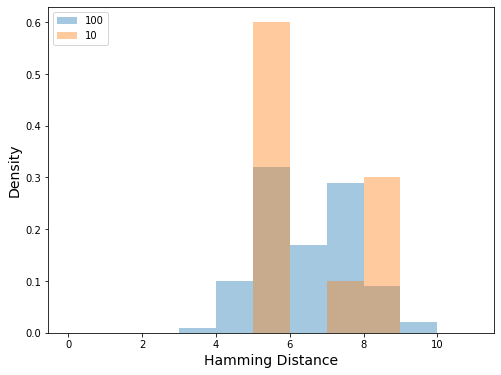

In [46]:
plt.figure(figsize=(8,6))

for topK in topKs:
    min_edit_dists = []
    for gen_seq in ddG_df.iloc[:topK]['MT_seq']:
        min_edit_dist = 99
        for train_seq in gen_train_df['MT_seq']:
            h_dist = hamming_dist(train_seq, gen_seq)
            if h_dist < min_edit_dist:
                min_edit_dist = h_dist

        min_edit_dists.append(min_edit_dist)

    topKs_min_edit_dists[topK] = min_edit_dists
    min_edit_mean = np.mean(min_edit_dists)
    min_edit_std = np.std(min_edit_dists)
    
    
    min_edit_min = np.min(min_edit_dists)
    min_edit_max = np.max(min_edit_dists)
    
    print("topK: ", topK)

    print("min_edit_min: ", min_edit_min)
    print("min_edit_max: ", min_edit_max)

    print("min_edit_mean: ", min_edit_mean)
    print("min_edit_std: ", min_edit_std)
    print("len(min_edit_dists): ", len(min_edit_dists))
    print("-----------")

    plt.hist(min_edit_dists, density=True, label=topK, bins=[i for i in range(12)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

# plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
# plt.title("Top 5% Generator")
plt.legend(loc='upper left')

In [47]:

# plt.figure(figsize=(8,6))
# plt.hist(min_edit_dists, density=True, label='generated', bins=[i for i in range(46)], alpha=0.4)
# # plt.xlabel("Hamming Distance", size=14)
# # plt.ylabel("Count", size=14)
# # plt.title("Hamming Distance from WT seq")

# plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Density", size=14)
# plt.title("Top 5% Generator")
# plt.legend(loc='upper left')

# Analyze Edit Distance for Generation vs Input Seqs

In [48]:
file_perturb = 'edit_analysis/congen_v1/small_clspool_waeDeterencStart84kstep512dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-070/edit_analysis_small_clspool_waeDeterencStart84kstep512dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-070-congen_seqs12500.tsv'
file_noperturb = 'edit_analysis/congen_v1/clspool_lre-04_gen_noperturb/edit_analysis_clspool_lre-04_gen_noperturb-congen_seqs12500.tsv'

df_perturb = pd.read_table(file_perturb)
df_noperturb = pd.read_table(file_noperturb)


FileNotFoundError: [Errno 2] No such file or directory: 'edit_analysis/congen_v1/small_clspool_waeDeterencStart84kstep512dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-070/edit_analysis_small_clspool_waeDeterencStart84kstep512dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-070-congen_seqs12500.tsv'

In [ ]:
h_dist_list_perturb = []
for ind, row in df_perturb.iterrows():
#     print("ind: ", ind)
# #     print("row: ", row)
#     print("row gen_input_seq: ", row['gen_input_seq'])
#     print("row MT_seq: ", row['MT_seq'])
    train_seq = row['gen_input_seq']
    gen_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, gen_seq)
    h_dist_list_perturb.append(h_dist)
    

h_dist_mean = np.mean(h_dist_list_perturb)
h_dist_std = np.std(h_dist_list_perturb)


h_dist_min = np.min(h_dist_list_perturb)
h_dist_max = np.max(h_dist_list_perturb)


print("h_dist_min: ", h_dist_min)
print("h_dist_max: ", h_dist_max)

print("h_dist_mean: ", h_dist_mean)
print("h_dist_std: ", h_dist_std)

In [ ]:
h_dist_list_noperturb = []
for ind, row in df_noperturb.iterrows():
#     print("ind: ", ind)
# #     print("row: ", row)
#     print("row gen_input_seq: ", row['gen_input_seq'])
#     print("row MT_seq: ", row['MT_seq'])
    train_seq = row['gen_input_seq']
    gen_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, gen_seq)
    h_dist_list_noperturb.append(h_dist)
    

h_dist_mean = np.mean(h_dist_list_noperturb)
h_dist_std = np.std(h_dist_list_noperturb)


h_dist_min = np.min(h_dist_list_noperturb)
h_dist_max = np.max(h_dist_list_noperturb)


print("h_dist_min: ", h_dist_min)
print("h_dist_max: ", h_dist_max)

print("h_dist_mean: ", h_dist_mean)
print("h_dist_std: ", h_dist_std)

In [ ]:

plt.figure(figsize=(8,6))
plt.hist(h_dist_list_noperturb, density=True, label='no perturbation', bins=[i for i in range(50)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(h_dist_list_perturb, density=True, label='with perturbation', bins=[i for i in range(50)], alpha=0.4)
plt.xlabel("Edit Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Min Edit Distance")
plt.legend(loc='upper left')

In [ ]:

plt.figure(figsize=(8,6))
plt.hist(h_dist_list_noperturb, density=True, label='no perturbation', bins=[i for i in range(12)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(h_dist_list_perturb, density=True, label='with perturbation', bins=[i for i in range(12)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Hamming Distance")
plt.legend(loc='upper right')